In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("Balance_Subj_DATA.csv")

In [3]:
df.head()

,FileID,Subject,SubjID,CzTheta
0,1130,Control,1,0.018762
1,1140,Control,1,0.012997
2,1150,Control,1,0.018516
3,1160,Control,1,0.019843
4,1170,Control,1,0.014810


In [4]:
#Splitting data into train and test sets
from sklearn.model_selection import train_test_split
np.random.seed(42)

x = df.drop(["FileID", "Subject","SubjID"], axis=1)
y = df["SubjID"]

x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.4)

In [5]:
x[:5]

,CzTheta
0,0.018762
1,0.012997
2,0.018516
3,0.019843
4,0.014810


In [6]:
y[:10]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: SubjID, dtype: int64

In [7]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestRegressor

In [8]:
#Putting the models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(max_iter= 1000), 
          "Random Forest": RandomForestClassifier(),
          "SVM": svm.SVC(),
          "Decision Tree": DecisionTreeClassifier(random_state=0),
          "RandomForestRegressor": RandomForestRegressor(n_estimators=10,
                                                         criterion="mse",
                                                         min_samples_leaf=3,
                                                         min_samples_split=3,
                                                         max_depth=10
                                   ),                                  
          "GNB": GaussianNB()}

#Creating a function to fit and kepp track of the scores
def fit_and_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    x_train : training data
    x_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Making a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        model.fit(x_train, y_train)
        
        model_scores[name] = model.score(x_test, y_test)
    return model_scores

In [9]:
model_scores = fit_and_score(models,
                             x_train,
                             x_test,
                             y_train,
                             y_test)

model_scores

{'KNN': 0.4,
 'Logistic Regression': 0.4,
 'Random Forest': 0.26666666666666666,
 'SVM': 0.3333333333333333,
 'Decision Tree': 0.26666666666666666,
 'RandomForestRegressor': 0.20245179988662132,
 'GNB': 0.3333333333333333}

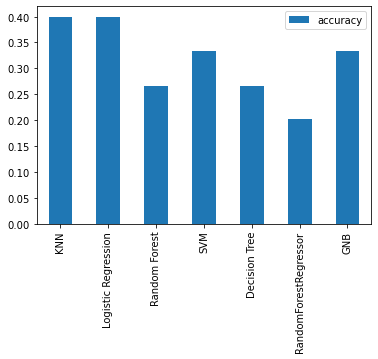

In [10]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

### Hyperparameter Tuning the KNN and Logistic Regression model using RandomizedSearchCV

In [11]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [12]:
np.random.seed(42)
kn_grid = { 'n_neighbors' : list(range(1,13)),
            'weights' : ['uniform','distance'],
            'metric' : ['minkowski','euclidean','manhattan'],
             'n_neighbors': list(range(1,5)),
             'leaf_size': list(range(1,5)),
            'p': list(range(1,5))}

kn_rscv = RandomizedSearchCV(KNeighborsClassifier(),
                             param_distributions =kn_grid,
                             cv=5,
                             n_jobs=-1,
                             verbose=True,
                             )
kn_rscv.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'leaf_size': [1, 2, 3, 4],
                                        'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': [1, 2, 3, 4],
                                        'p': [1, 2, 3, 4],
                                        'weights': ['uniform', 'distance']},
                   verbose=True)

In [13]:
kn_rscv.best_params_

{'weights': 'uniform',
 'p': 3,
 'n_neighbors': 2,
 'metric': 'manhattan',
 'leaf_size': 3}

In [14]:
kn_rscv.score(x_test, y_test)

0.6

In [15]:
#Grid for LogisticRegression
lr_grid = {"C": np.logspace(-4,4,10),
           'penalty': ['l1', 'l2'],
           'max_iter': list(range(1,10,5)),
           'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [16]:
#Tuning LogisticsRegression
np.random.seed(42)

rscv_lr = RandomizedSearchCV(LogisticRegression(),
                           param_distributions=lr_grid,
                           n_iter=5,
                           verbose=True)

#Fitting the model
rscv_lr.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(estimator=LogisticRegression(), n_iter=5,
                   param_distributions={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                                        'max_iter': [1, 6],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   verbose=True)

In [17]:
rscv_lr.best_params_

{'solver': 'newton-cg',
 'penalty': 'l2',
 'max_iter': 6,
 'C': 0.3593813663804626}

In [18]:
rscv_lr.score(x_test,y_test)

0.4

### Applying GridSearchCV

In [19]:
np.random.seed(42)
gs_knn = GridSearchCV(KNeighborsClassifier(),
                      param_grid=kn_grid,
                     verbose=True)
gs_knn.fit(x_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3, 4],
                         'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4], 'p': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [20]:
gs_knn.best_params_

{'leaf_size': 1,
 'metric': 'minkowski',
 'n_neighbors': 2,
 'p': 1,
 'weights': 'uniform'}

In [21]:
gs_knn.score(x_test, y_test)

0.6

In [22]:
np.random.seed(42)
gs_lr = GridSearchCV(LogisticRegression(),
                      param_grid=lr_grid,
                     verbose=True)
gs_lr.fit(x_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'max_iter': [1, 6], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=True)

In [23]:
gs_lr.best_params_

{'C': 10000.0, 'max_iter': 6, 'penalty': 'l2', 'solver': 'newton-cg'}

In [24]:
gs_lr.score(x_test, y_test)

0.4666666666666667

In [25]:
y_preds = gs_knn.predict(x_test)

[[6 0 0]
 [1 2 0]
 [2 3 1]]


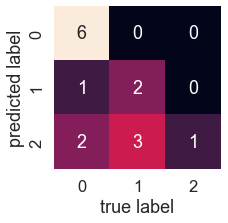

In [26]:
#Confusion Matrix
print(confusion_matrix(y_test, y_preds))

sns.set(font_scale=1.5) 

def plot_confmat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_confmat(y_test, y_preds)

In [27]:
print(f"Training score :===> {gs_knn.score(x_train, y_train)}")
print(f"Testing score  :===> {gs_knn.score(x_test, y_test)}")

Training score :===> 0.7619047619047619
Testing score  :===> 0.6


In [28]:
#Classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.67      1.00      0.80         6
           2       0.40      0.67      0.50         3
           3       1.00      0.17      0.29         6

    accuracy                           0.60        15
   macro avg       0.69      0.61      0.53        15
weighted avg       0.75      0.60      0.53        15



In [29]:
gs_knn.best_params_

{'leaf_size': 1,
 'metric': 'minkowski',
 'n_neighbors': 2,
 'p': 1,
 'weights': 'uniform'}

In [30]:
clf = KNeighborsClassifier(leaf_size= 1,
                           metric= 'minkowski',
                           n_neighbors= 2,
                           p= 1,
                           weights= 'uniform')

In [31]:
#Cross validated accuracy
cv_acc = cross_val_score(clf,
                         x,
                         y, 
                         scoring="accuracy") 
cv_acc = np.mean(cv_acc)
cv_acc

0.6142857142857142